In [1]:
import random
import warnings

import pandas as pd
from IPython.display import HTML, Markdown, display
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from utility import CASE, METHO, VALID, check_job_title, clean_skills, init_jobs

In [2]:
warnings.filterwarnings("ignore")

In [3]:
HTML(
    """
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

# Introduction

job mismatch dilemma intro

# Statement of the Problem

The job skill mismatch dilemma presents a significant challenge, causing inefficiencies in hiring processes. To mitigate this, a streamlined solution is needed to recommend skills for enhancing applicant hirability and enabling employers to efficiently select and rank candidates with the help of frequent itemset mining (fim) association rules.

# Dataset Overview

The LinkedIn dataset, extracted from Kaggle, comprises three distinct CSV files: job_postings.csv, job_skills.csv, and job_summary.csv. Each file contains 12,217 rows, which were merged using the "job_link" column.

There are no null or NaN rows in the dataset, hence no data imputation or rows were dropped.

In [4]:
merged_df = init_jobs()
merged_df.info()

12217

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12217 non-null  object
 1   job_summary          12217 non-null  object
 2   last_processed_time  12217 non-null  object
 3   last_status          12217 non-null  object
 4   got_summary          12217 non-null  object
 5   got_ner              12217 non-null  object
 6   is_being_worked      12217 non-null  object
 7   job_title            12217 non-null  object
 8   company              12217 non-null  object
 9   job_location         12216 non-null  object
 10  first_seen           12217 non-null  object
 11  search_city          12217 non-null  object
 12  search_country       12217 non-null  object
 13  search_position      12217 non-null  object
 14  job_level            12217 non-null  object
 15  job_type             12217 non-null  object
 16  job_

To standardize the job titles, the team implemented a categorization system for common roles like 'Data Scientist', 'Data Analyst', etc. 

This categorization process also eliminated indications of job levels in the titles, such as 'senior', 'junior', or 'associate'. Additionally, due to the higher number of 'Mid senior' positions compared to 'Associate' positions, the team chose not to distinguish between job levels.

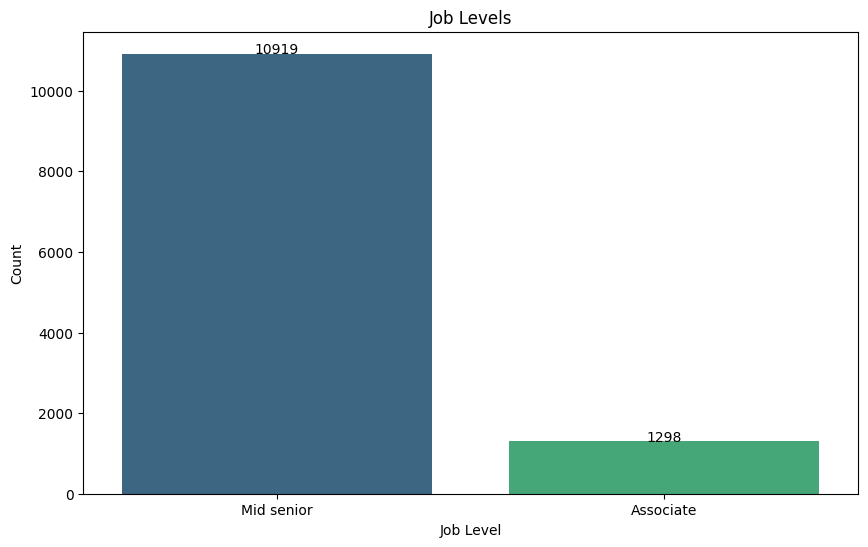

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

job_level_counts = merged_df['job_level'].value_counts().reset_index()
job_level_counts.columns = ['Job Level', 'Count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=job_level_counts, x='Job Level', y='Count', palette='viridis')
plt.title('Job Levels')
plt.xlabel('Job Level')
plt.ylabel('Count')

# Annotate bars with counts
for index, row in job_level_counts.iterrows():
    ax.text(row.name, row['Count']+0.2, row['Count'], color='black', ha="center")

plt.show()


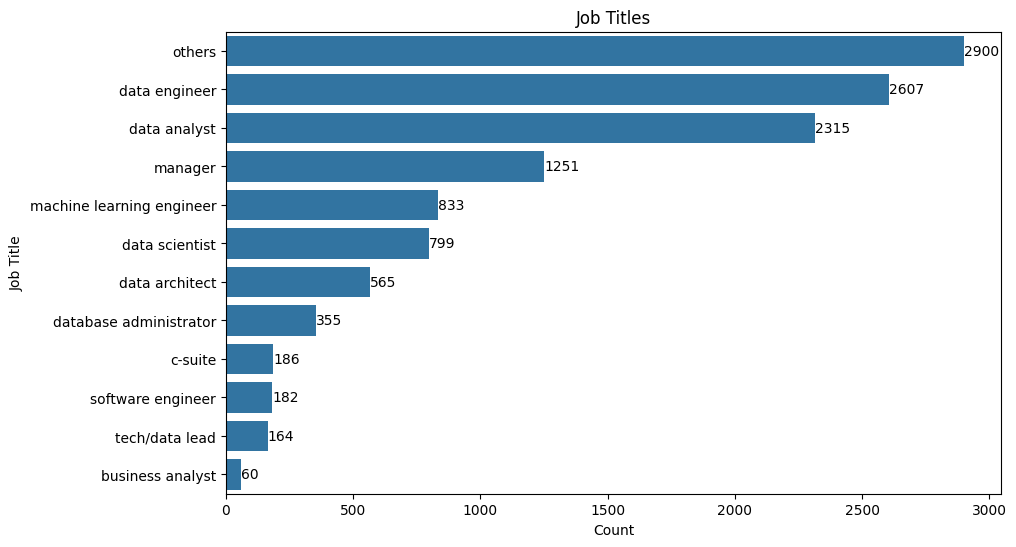

In [6]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
job_title_counts = merged_df['job_title_new'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=merged_df, y='job_title_new', order=job_title_counts.index)
plt.title('Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')

for i, count in enumerate(job_title_counts):
    ax.text(count, i, str(count), ha='left', va='center')

plt.show()


In [7]:
from wordcloud import WordCloud, STOPWORDS

all_job_skills = ""
for job_skill_list in merged_df['job_summary'].tolist():
    for job_skill in job_skill_list:
        all_job_skills += str(job_skill.lower()) + " "

wordcloud = WordCloud(scale=10,
                      background_color='white',
                      stopwords=set(STOPWORDS),
                      min_font_size=8).generate(all_job_skills)

plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("WordCloud for Job Titles")
plt.show()


KeyboardInterrupt: 

# Methodology

## Merged Dataframe

Prepared input CSVs to a merged dataframe for processing

In [4]:
merged_df = init_jobs()

12217

## Jobs binning

Binning jobs for selection later when cases are created where one person wants to transition into one of the binned roles.

In [5]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
merged_df["job_title_new"].value_counts()

job_title_new
others                       2900
data engineer                2607
data analyst                 2315
manager                      1251
machine learning engineer     833
data scientist                799
data architect                565
database administrator        355
c-suite                       186
software engineer             182
tech/data lead                164
business analyst               60
Name: count, dtype: int64

create new column `job_skills_` list of skills for the job

In [6]:
merged_df["job_skills_"] = merged_df["job_skills"].apply(clean_skills)

Bin job titles into these job titles:
- data engineer 
- data scientist 
- data analyst 
- business analyst 
- database engineer 
- database administrator 
- data architect 
- machine learning/mlops engineer 
- software engineer 
- tech lead 

## Base Transaction Database

This will be the base database for filtering later when we filter by job title.

In [7]:
merged_df[["job_link", "job_title_new", "job_skills_"]].head(6)

,job_link,job_title_new,job_skills_
0,https://www.linkedin.com/jobs/view/senior-mach...,machine learning engineer,"[machine learning, programming, python, scala,..."
1,https://www.linkedin.com/jobs/view/principal-s...,software engineer,"[c++, python, pytorch, tensorflow, mxnet, cuda..."
2,https://www.linkedin.com/jobs/view/senior-etl-...,data engineer,"[etl, data integration, data transformation, d..."
3,https://www.linkedin.com/jobs/view/senior-data...,data architect,"[data lakes, data bricks, azure data factory p..."
4,https://www.linkedin.com/jobs/view/lead-data-e...,data engineer,"[java, scala, python, rdbms, nosql, redshift, ..."
5,https://www.linkedin.com/jobs/view/senior-data...,data engineer,"[data warehouse (dw), extract/transform/load (..."


## Using FIM to recommend skills to add to a person

In this project we'll be using FIM to recommend skills to a person given a base skillset. To recommend we will first create the frequent itemset using `fpgrowth` in `mlexted` library using `mlextend.fpgrowth` function and then getting associated association rules using `mlexted.association_rules` function. From the association rules, we will filter the antecedents based on the input base skills, order the rules by list and get top consequents that it unique and not already in the input base skills. We will then define a validation process below.

\begin{align}
\text{Probability to get job} &= \frac{\text{no. skills matched}}{\text{no. skills required by job}} \\
\text{Hirability} &= \text{Probability of getting any jobs in the current DB} = \frac{\sum_{i=1}^{n}\text{Probability to get job}_i}{\text{total transactions in DB (n)}}
\end{align}

We'll quote the above metric as $Hirability$ based on what skills you have. $Hirability$ will be then compared for:
- Base Case (base skills only)
- Stochastic Case (add n randomly sourced skills)
- FIM Case (add n skills with most lift in the association rules)

In this project we'll be using Base Case as the baseline. Stochastic case as the "usual" method of expanding skills (in real life this is not entirely true but we'll use this as some kind of a PCC metric that will define your hirability by adding random skills). Finally, FIM case will be the alternative case. We will then check with the sample cases below the performance of all 3 based on their computed $Hirability$.

In [8]:
def skill_fim(merged_df, job_tit, support):
    print(f"Wanting to transition to {job_tit}...")
    db = merged_df[merged_df["job_title_new"] == job_tit]
    dataset = db["job_skills_"].to_list()
    print(f"Size of DB: {len(dataset)}")
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)

    rules = association_rules(frequent_itemsets, metric="lift")
    rules = rules[rules["antecedents"].isin(frequent_itemsets["itemsets"].to_list())]
    rules["a_cnt"] = rules["antecedents"].apply(len)
    rules["c_cnt"] = rules["consequents"].apply(len)
    rules = rules.sort_values(by=["c_cnt", "lift", "support"], ascending=False)
    return rules, frequent_itemsets, db

In [9]:
def get_skills_probability(job_database, skills_to_match):
    job_database["acceptance_prob"] = job_database["job_skills_"].apply(
        lambda x: len(skills_to_match.intersection(x)) / len(x)
    )
    prob = round((job_database["acceptance_prob"].sum() / len(job_database)) * 100, 4)
    return prob, job_database["acceptance_prob"].sum(), len(job_database)

In [10]:
def test_fim(merged_df, job_tit, supp, base_skills, no_skills_to_add):
    c_rules, c_fi, c_db = skill_fim(merged_df, job_tit, supp)
    display(Markdown(f"{job_tit.upper()} frequent itemset:"))
    display(c_fi)
    display(Markdown("Search frequent itemset if base skill in it:"))
    display(c_fi[c_fi["itemsets"] <= base_skills])
    display(
        Markdown(
            METHO.format(
                base_skills,
                base_skills,
                no_skills_to_add,
                base_skills,
                no_skills_to_add,
            )
        )
    )

    display(Markdown("### Base Case"))
    prob, job_cnt, job_total = get_skills_probability(c_db, base_skills)
    print(
        CASE.format(
            base_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    base = prob

    display(Markdown("### Stochastic Case"))
    display(
        Markdown(
            f"Get hirability when {no_skills_to_add} random skills are added to base case, have 100 iterations and get the average"
        )
    )
    prob_list = []
    for i in range(100):
        choice = set(
            [item for sublist in c_db["job_skills_"].tolist() for item in sublist]
        )
        random_skill = random.sample(list(choice), no_skills_to_add)
        skills_to_match = base_skills.union(random_skill)
        prob_list.append(get_skills_probability(c_db, skills_to_match)[0])
    average = sum(prob_list) / len(prob_list)
    print(
        CASE.format(
            f"{base_skills} plus {no_skills_to_add} random skills, 100 iterations then get average",
            round(average, 4),
            round(round(average * len(c_db) / 100)),
            len(c_db),
            len(c_db),
            job_tit,
            round(round(average * len(c_db) / 100)),
        )
    )
    stochastic = average

    display(Markdown("### FIM Case"))
    display(
        Markdown(
            f"From the association rules above get top {no_skills_to_add} skills consequents with highest lift and add to skills"
        )
    )
    most_lift = c_rules[
        c_rules["antecedents"].apply(lambda rules: rules <= base_skills)
    ].sort_values(by=["lift"], ascending=False)
    display(most_lift)
    consequents = [list(fs) for fs in most_lift["consequents"].to_list()]
    fim_skills = []
    consequents_ = [item for sublist in consequents for item in sublist]
    [fim_skills.append(i) for i in consequents_ if i not in fim_skills]
    fim_skills = [i for i in fim_skills if i not in base_skills][:no_skills_to_add]
    fim_skills = base_skills.union(fim_skills)
    prob, job_cnt, job_total = get_skills_probability(c_db, fim_skills)
    print(
        CASE.format(
            fim_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    fim = prob

    display(Markdown("### Validation"))
    display(Markdown(VALID.format(round(base, 4), round(stochastic, 4), round(fim, 4))))

# Results and Discussion

## Case 1 - Fresh Grad to Data Scientist
with basic python and numpy knowledge, wants to be Data scientist

In [11]:
base_skills = {"python", "pandas", "numpy"}
test_fim(
    merged_df=merged_df,
    job_tit="data scientist",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
)

Wanting to transition to data scientist...
Size of DB: 799


DATA SCIENTIST frequent itemset:

,support,itemsets
0,0.829787,(python)
1,0.719650,(machine learning)
2,0.670839,(data science)
3,0.485607,(r)
4,0.384230,(data visualization)
...,...,...
1887,0.053817,"(nlp, sql)"
1888,0.065081,"(nlp, python, machine learning)"
1889,0.053817,"(nlp, python, data science)"
1890,0.052566,"(nlp, data science, machine learning)"


Search frequent itemset if base skill in it:

,support,itemsets
0,0.829787,(python)
33,0.077597,(pandas)
70,0.073842,(numpy)
1273,0.071339,"(pandas, python)"
1872,0.071339,"(python, numpy)"
1873,0.063830,"(pandas, numpy)"
1877,0.061327,"(pandas, python, numpy)"


Comparing Hirability for:
- base `{'pandas', 'python', 'numpy'}`
- `{'pandas', 'python', 'numpy'}` plus 6 random sampled skills without replacement
- `{'pandas', 'python', 'numpy'}` plus 6 unique skills recommended by fim with highest lift


### Base Case

Skillset: {'pandas', 'python', 'numpy'}
Hirability: 4.006%
Jobs available: 32/799
Applying in all 799 data scientist jobs, you are likely to get into 32



### Stochastic Case

Get hirability when 6 random skills are added to base case, have 100 iterations and get the average

Skillset: {'pandas', 'python', 'numpy'} plus 6 random skills, 100 iterations then get average
Hirability: 4.112%
Jobs available: 33/799
Applying in all 799 data scientist jobs, you are likely to get into 33



### FIM Case

From the association rules above get top 6 skills consequents with highest lift and add to skills

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,a_cnt,c_cnt
22825,(numpy),"(pandas, python)",0.073842,0.071339,0.061327,0.830508,11.641689,0.056059,5.479099,0.986983,1,2
22820,"(pandas, python)",(numpy),0.071339,0.073842,0.061327,0.859649,11.641689,0.056059,6.598874,0.984323,2,1
22813,(numpy),(pandas),0.073842,0.077597,0.063830,0.864407,11.139694,0.058100,6.802722,0.982803,1,1
22812,(pandas),(numpy),0.077597,0.073842,0.063830,0.822581,11.139694,0.058100,5.220162,0.986804,1,1
22823,(pandas),"(python, numpy)",0.077597,0.071339,0.061327,0.790323,11.078381,0.055791,4.428998,0.986265,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
22214,(python),(project management),0.829787,0.098874,0.078849,0.095023,0.961052,-0.003195,0.995745,-0.192308,1,1
14991,(python),"(mathematics, computer science)",0.829787,0.111389,0.087610,0.105581,0.947854,-0.004820,0.993506,-0.244265,1,2
22130,(python),"(leadership, machine learning)",0.829787,0.070088,0.055069,0.066365,0.946886,-0.003089,0.996013,-0.247863,1,2
16302,(python),(operations research),0.829787,0.071339,0.052566,0.063348,0.887989,-0.006631,0.991469,-0.425641,1,1


Skillset: {'pandas', 'numpy', 'statistics', 'python', 'machine learning', 'tensorflow', 'data science', 'spark', 'scikitlearn'}
Hirability: 13.2442%
Jobs available: 106/799
Applying in all 799 data scientist jobs, you are likely to get into 106



### Validation

Result:
- 4.006 % Hirability (base)
- 4.112 % Hirability (stochastic)
- 13.2442 % Hirability (fim)

Hirability increase better in fim case compared to stochastic case!


## Case 2 - Data Engineer to Tech Lead

In [12]:
base_skills = {"python", "spark", "hadoop", "sql"}
test_fim(
    merged_df=merged_df,
    job_tit="tech/data lead",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
)

Wanting to transition to tech/data lead...
Size of DB: 164


TECH/DATA LEAD frequent itemset:

,support,itemsets
0,0.170732,(communication skills)
1,0.237805,(python)
2,0.182927,(communication)
3,0.128049,(data integration)
4,0.115854,(analytical skills)
...,...,...
86,0.067073,"(project management, leadership)"
87,0.060976,"(problem solving, leadership)"
88,0.054878,"(data integration, data modeling)"
89,0.060976,"(project management, problem solving)"


Search frequent itemset if base skill in it:

,support,itemsets
1,0.237805,(python)
7,0.243902,(sql)
15,0.060976,(spark)
51,0.158537,"(python, sql)"


Comparing Hirability for:
- base `{'hadoop', 'python', 'sql', 'spark'}`
- `{'hadoop', 'python', 'sql', 'spark'}` plus 6 random sampled skills without replacement
- `{'hadoop', 'python', 'sql', 'spark'}` plus 6 unique skills recommended by fim with highest lift


### Base Case

Skillset: {'hadoop', 'python', 'sql', 'spark'}
Hirability: 2.4556%
Jobs available: 4/164
Applying in all 164 tech/data lead jobs, you are likely to get into 4



### Stochastic Case

Get hirability when 6 random skills are added to base case, have 100 iterations and get the average

Skillset: {'hadoop', 'python', 'sql', 'spark'} plus 6 random skills, 100 iterations then get average
Hirability: 2.6729%
Jobs available: 4/164
Applying in all 164 tech/data lead jobs, you are likely to get into 4



### FIM Case

From the association rules above get top 6 skills consequents with highest lift and add to skills

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,a_cnt,c_cnt
28,(python),(data mining),0.237805,0.067073,0.054878,0.230769,3.440559,0.038928,1.212805,0.930667,1,1
59,(python),(databricks),0.237805,0.103659,0.073171,0.307692,2.968326,0.048520,1.294715,0.870000,1,1
2,(python),(sql),0.237805,0.243902,0.158537,0.666667,2.733333,0.100535,2.268293,0.832000,1,1
3,(sql),(python),0.243902,0.237805,0.158537,0.650000,2.733333,0.100535,2.177700,0.838710,1,1
18,(python),(machine learning),0.237805,0.115854,0.073171,0.307692,2.655870,0.045620,1.277100,0.818000,1,1
22,(python),(data warehousing),0.237805,0.103659,0.054878,0.230769,2.226244,0.030228,1.165244,0.722667,1,1
25,(sql),(data warehousing),0.243902,0.103659,0.054878,0.225000,2.170588,0.029595,1.156570,0.713262,1,1
61,(sql),(databricks),0.243902,0.103659,0.054878,0.225000,2.170588,0.029595,1.156570,0.713262,1,1
20,(sql),(machine learning),0.243902,0.115854,0.060976,0.250000,2.157895,0.032719,1.178862,0.709677,1,1
68,(python),(data architecture),0.237805,0.134146,0.054878,0.230769,1.720280,0.022977,1.125610,0.549333,1,1


Skillset: {'hadoop', 'sql', 'python', 'data warehousing', 'data architecture', 'data analytics', 'data mining', 'machine learning', 'databricks', 'spark'}
Hirability: 5.0865%
Jobs available: 8/164
Applying in all 164 tech/data lead jobs, you are likely to get into 8



### Validation

Result:
- 2.4556 % Hirability (base)
- 2.6729 % Hirability (stochastic)
- 5.0865 % Hirability (fim)

Hirability increase better in fim case compared to stochastic case!


# Conclusion

# Recommendation

# References